In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt|
import plotly.graph_objects as go
from statsmodels import api as sm
import plotly.subplots as sp
import math
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Exploring the Data

In [4]:
df= pd.read_csv(r"C:\Users\47462\OneDrive\Desktop\Time Series Analysi\weekly_customer_complaints.csv")
df.head()


,week,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
0,1/1/2018,"1,750",37.26%,1,0,0
1,1/8/2018,"1,701",35.38%,0,0,0
2,1/15/2018,"1,711",36.22%,1,0,0
3,1/22/2018,"1,443",38.33%,1,0,0
4,1/29/2018,"1,397",36.34%,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   week                     261 non-null    object
 1   complaints               261 non-null    object
 2   discount_rate            261 non-null    object
 3   small_commercial_event   261 non-null    int64 
 4   medium_commercial_event  261 non-null    int64 
 5   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 12.4+ KB


In [6]:
df.describe()

,small_commercial_event,medium_commercial_event,big_commercial_event
count,261.000000,261.000000,261.000000
mean,0.226054,0.118774,0.026820
std,0.419078,0.324144,0.161867
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [7]:
#convert the date to datetime format

df["week"] = pd.to_datetime(df["week"])

df = df.sort_values('week')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 260
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   week                     261 non-null    datetime64[ns]
 1   complaints               261 non-null    object        
 2   discount_rate            261 non-null    object        
 3   small_commercial_event   261 non-null    int64         
 4   medium_commercial_event  261 non-null    int64         
 5   big_commercial_event     261 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 14.3+ KB


In [8]:
# and set date as index

df.set_index('week',inplace=True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


# Data Pre-Processing


In [9]:
# remove comma and transform to 
df['complaints']=df['complaints'].str.replace(',','').astype(float)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750.0,37.26%,1,0,0
2018-01-08,1701.0,35.38%,0,0,0
2018-01-15,1711.0,36.22%,1,0,0
2018-01-22,1443.0,38.33%,1,0,0
2018-01-29,1397.0,36.34%,0,0,0


In [10]:
#set frequency 
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

In [11]:
#setting freq to W implies that week starts on a sunday
df=df.asfreq("W-Mon")

In [12]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq='W-MON')

# Exploratory Data Analysis

In [13]:
# finding null values

print(df.isnull().sum())

complaints                 0
discount_rate              0
small_commercial_event     0
medium_commercial_event    0
big_commercial_event       0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

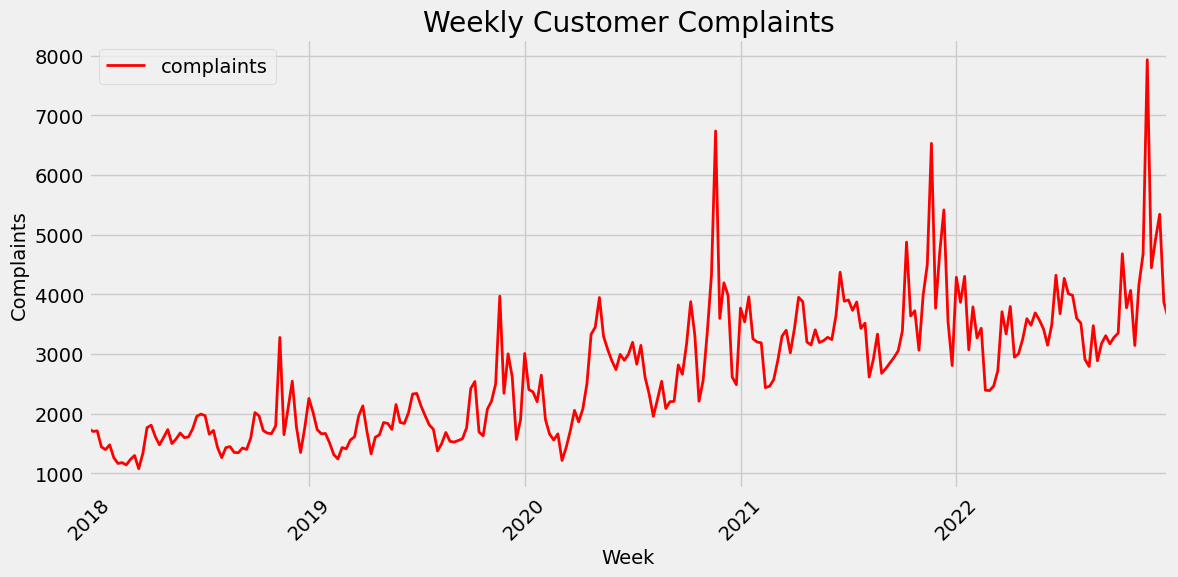

In [14]:
# Let's see some more visualizations for understanding
# Daily closing price plot
df['complaints'].plot(title='Weekly Customer Complaints',figsize=(12, 6), color='red', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Complaints')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show

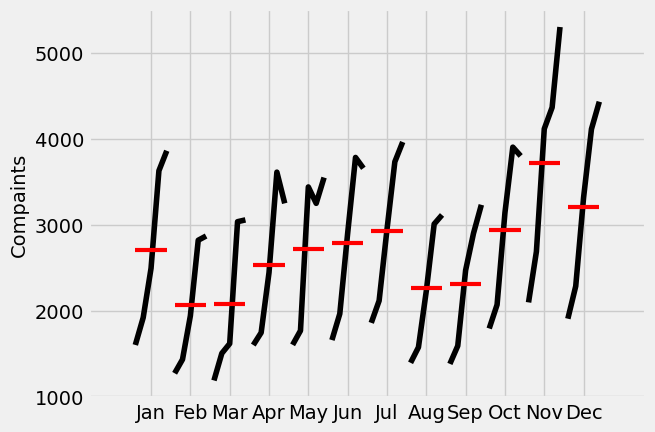

In [15]:
#plotting the monthly seaasonality

month_plot(df['complaints'].resample('M').mean(), ylabel='Compaints')
plt.show()

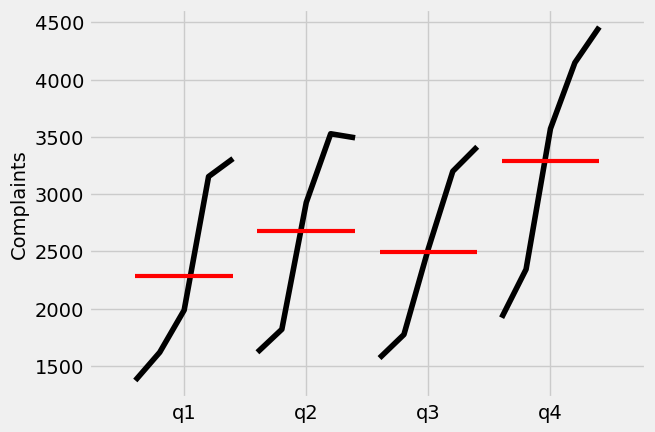

In [16]:
#plotting the monthly seaasonality

quarter_plot(df['complaints'].resample('Q').mean(), ylabel='Complaints')
plt.show()

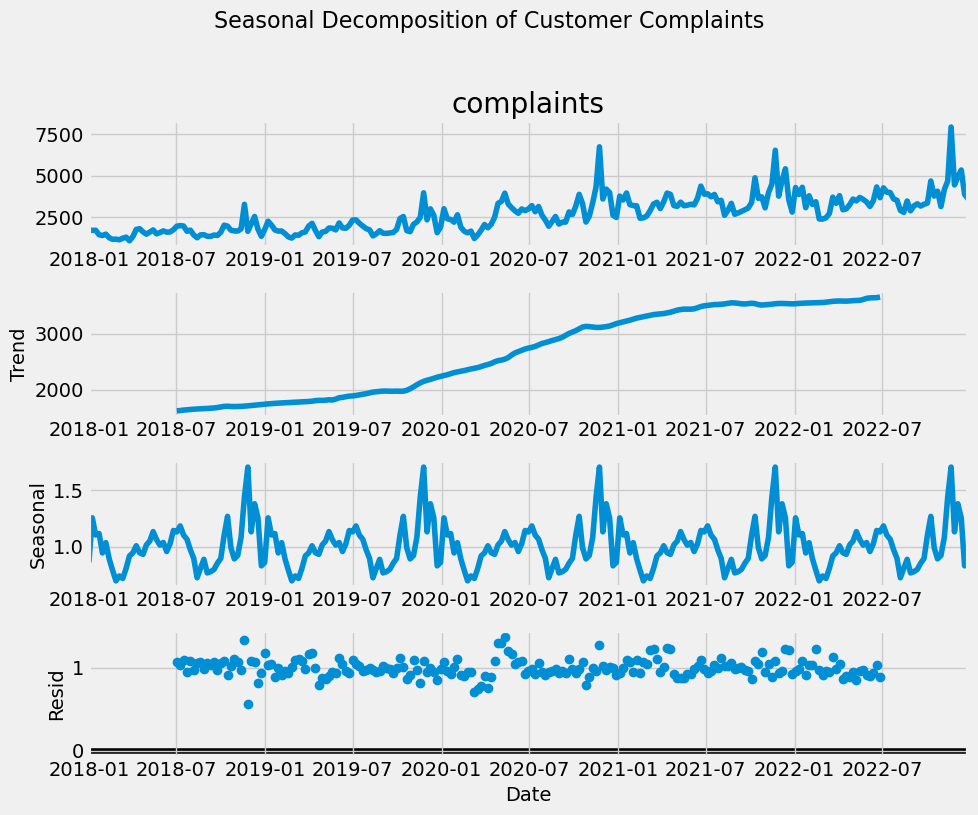

In [17]:
#seasonal decompostion plots for the data
# Seasonality:
# 24 for hourly
# 7 or 365 for daily, but in most cases 7 is preffered
# 52 for weekly
# 4 for quarterly
# 5 for weekdays

decomposition= seasonal_decompose(df['complaints'], 
                   model= 'multiplicative', 
                   period=52)

fig= decomposition.plot()
fig.set_size_inches(10,8)



    

    

fig.axes[-1].set_xlabel('Date')

fig.suptitle('Seasonal Decomposition of Customer Complaints', fontsize=16, y=1.02)

plt.tight_layout()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

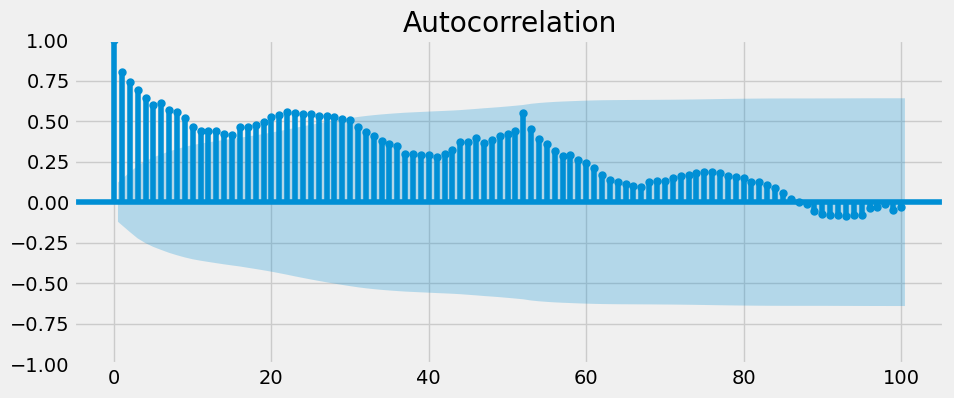

In [18]:

# Plot the autocorrelation (ACF)

fig, ax =plt.subplots(figsize=(10,4))

plot_acf(df['complaints'], lags=100, ax= ax)

plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

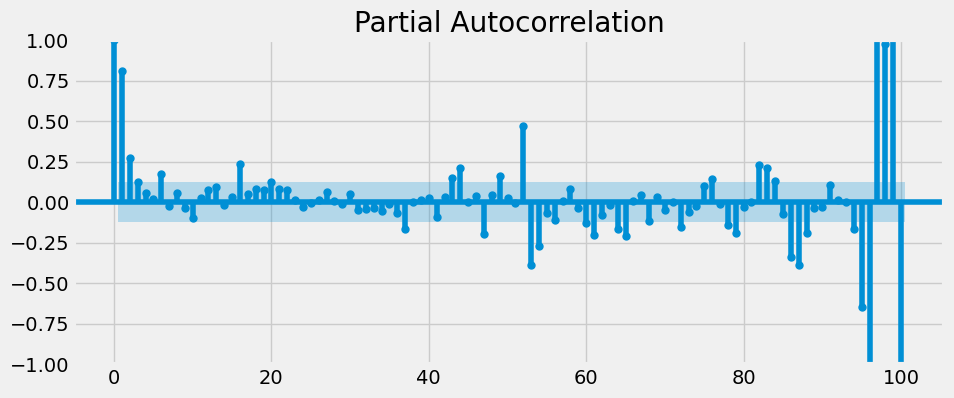

In [19]:
# partial autocorrelation (PACF), for soecific relationship between data points

fig, ax =plt.subplots(figsize=(10,4))

plot_pacf(df['complaints'], lags=100, ax= ax)

plt.show

# Spilliting the data to traing and testing

In [20]:
#training and test split
# Goal: to predict the next quarter (13 weeks)
periods=13
train,test= df.iloc[:-periods,0], df.iloc[-periods:, 0]





In [21]:
train.head()

week
2018-01-01    1750.0
2018-01-08    1701.0
2018-01-15    1711.0
2018-01-22    1443.0
2018-01-29    1397.0
Freq: W-MON, Name: complaints, dtype: float64

In [22]:
test.head()

week
2022-10-03    3350.0
2022-10-10    4679.0
2022-10-17    3773.0
2022-10-24    4065.0
2022-10-31    3142.0
Freq: W-MON, Name: complaints, dtype: float64

# Exponential Smoothing and Holt Winters

# Simple Exponential Smoothing


In [23]:
# Simple Exponential Smoothing Model and Prediction

model_simple= SimpleExpSmoothing(train).fit()
predictions_simple= model_simple.forecast(len(test))

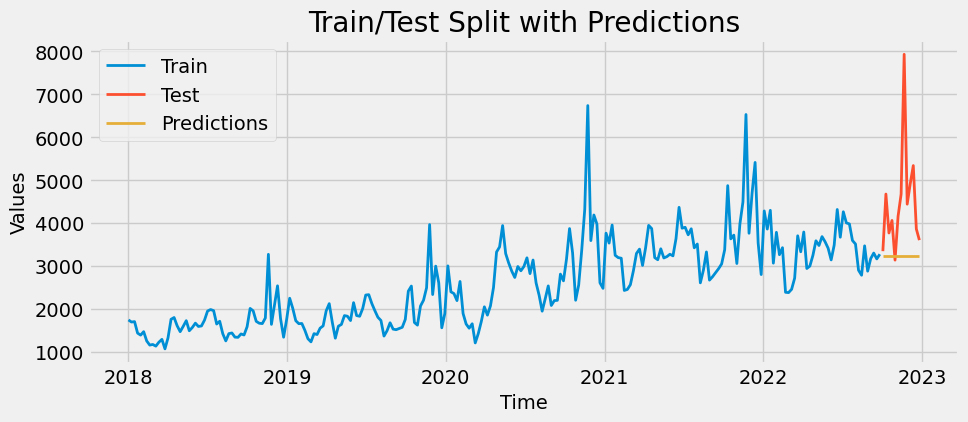

In [24]:


# Set figure size BEFORE plotting
plt.figure(figsize=(10, 4))  # Width=12 inches, Height=6 inches

plt.plot(train, label='Train', linewidth=2)
plt.plot(test, label='Test', linewidth=2)
plt.plot(predictions_simple, label='Predictions', linewidth=2)

plt.legend()  # Optional: to show labels
plt.title('Train/Test Split with Predictions')  # Optional: Add title
plt.xlabel('Time')  # Optional: Label x-axis
plt.ylabel('Values')  # Optional: Label y-axis

plt.show()



# Double Exponential Smoothing

In [25]:
# Double exponential smoothing model

model_double = ExponentialSmoothing(train,
                                    trend= 'mul',
                                   seasonal = None).fit()

In [26]:
#predictions
predictions_double= model_double.forecast(len(test))

predictions_double

2022-10-03    3257.344635
2022-10-10    3268.523454
2022-10-17    3279.740638
2022-10-24    3290.996318
2022-10-31    3302.290626
2022-11-07    3313.623695
2022-11-14    3324.995657
2022-11-21    3336.406647
2022-11-28    3347.856798
2022-12-05    3359.346245
2022-12-12    3370.875122
2022-12-19    3382.443564
2022-12-26    3394.051708
Freq: W-MON, dtype: float64

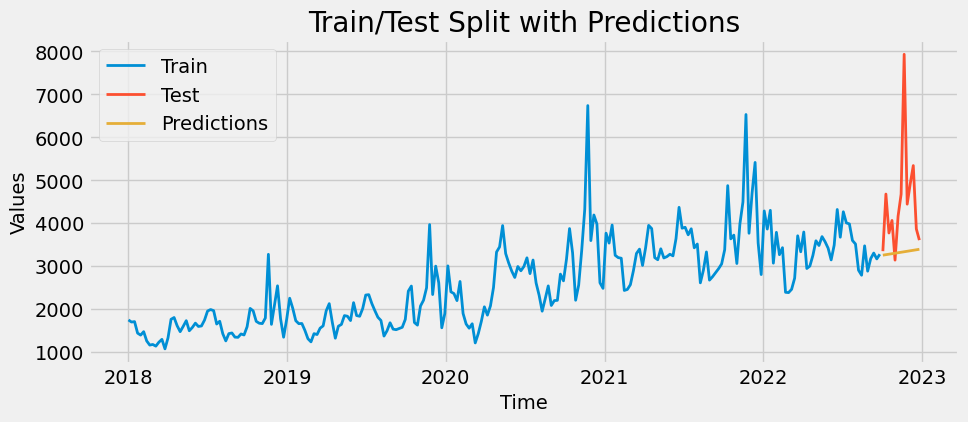

In [27]:


# plotting train, test and predictions
plt.figure(figsize=(10, 4))  

plt.plot(train, label='Train',linewidth=2)
plt.plot(test, label='Test',linewidth=2)
plt.plot(predictions_double, label='Predictions', linewidth=2)

plt.legend()  
plt.title('Train/Test Split with Predictions')  
plt.xlabel('Time')  
plt.ylabel('Values')  

plt.show()

# Tripple Exponential Smoothing(Holt-Winter Method)

In [28]:
#Tripple Exponential Smoothing

model_tripple = ExponentialSmoothing(train,
                                    trend= 'add',
                                   seasonal = 'mul',
                                    seasonal_periods= 52).fit()

In [29]:
#predictions
predictions_tripple= model_tripple.forecast(len(test))

predictions_tripple

2022-10-03    4010.525324
2022-10-10    5026.940572
2022-10-17    3897.956952
2022-10-24    3511.117627
2022-10-31    3396.151157
2022-11-07    4204.017420
2022-11-14    5307.130221
2022-11-21    7210.817166
2022-11-28    4290.209700
2022-12-05    5239.460210
2022-12-12    5225.972270
2022-12-19    3394.095855
2022-12-26    3238.163466
Freq: W-MON, dtype: float64

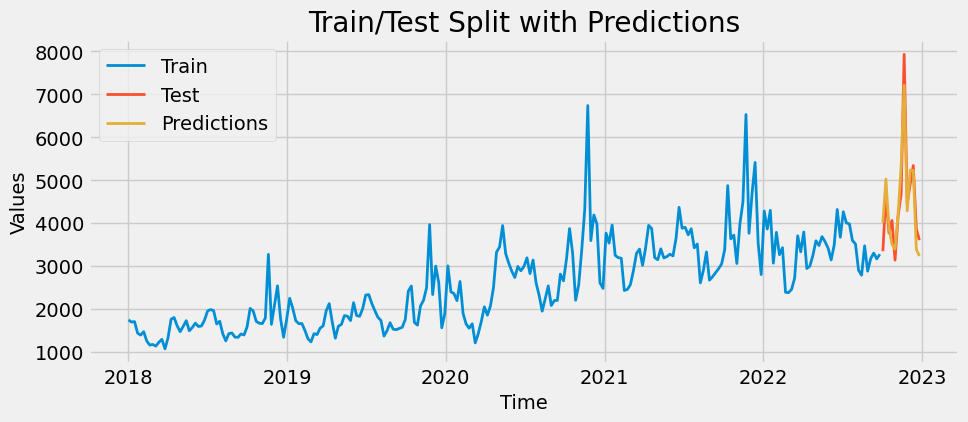

In [30]:


# plotting train, test and predictions
plt.figure(figsize=(10, 4))  

plt.plot(train, label='Train',linewidth=2)
plt.plot(test, label='Test',linewidth=2)
plt.plot(predictions_tripple, label='Predictions', linewidth=2)

plt.legend()  
plt.title('Train/Test Split with Predictions')  
plt.xlabel('Time')  
plt.ylabel('Values')  

plt.show()

# Calculating the MAE, RMSE,and MAPE



In [31]:
mae = mean_absolute_error(test,predictions_tripple)
print(f"The MAE is {mae:.2f}")

The MAE is 366.45


In [32]:
rmse = mean_squared_error(test,predictions_tripple, squared= False)
print(f"The RMSE is {rmse:.2f}")

The RMSE is 426.21


In [33]:
mape = mean_absolute_percentage_error(test,predictions_tripple)
print(f"The MAPE is {100*mape:.2f}%")

The MAPE is 8.48%


# function to assess model and visualize output

<Figure size 1000x400 with 0 Axes>

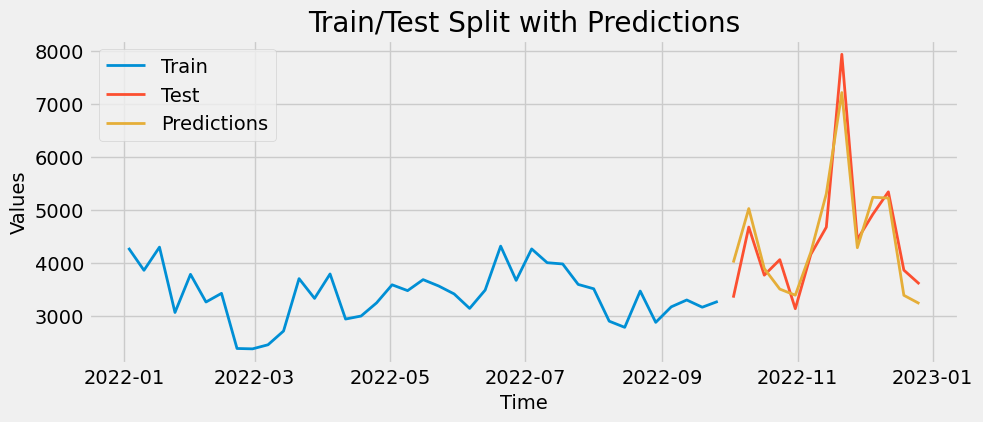

The MAE is 366.45
The RMSE is 426.21
The MAPE is 8.48%


In [34]:
def model_assessment(train, test, predictions, chart_title):
    plt.figure(figsize=(10, 4))  
    plt.figure(figsize=(10, 4))  

    plt.plot(train, label='Train',linewidth=2)
    plt.plot(test, label='Test',linewidth=2)
    plt.plot(predictions_tripple, label='Predictions', linewidth=2)

    plt.legend()  
    plt.title('Train/Test Split with Predictions')  
    plt.xlabel('Time')  
    plt.ylabel('Values')  

    plt.show()
    
    mae = mean_absolute_error(test,predictions)
    print(f"The MAE is {mae:.2f}")

    rmse = mean_squared_error(test,predictions, squared= False)
    print(f"The RMSE is {rmse:.2f}")
    
    mape = mean_absolute_percentage_error(test,predictions)
    print(f"The MAPE is {100*mape:.2f}%")
    
model_assessment(train['2022'],test, predictions_tripple, "Holt-Winters")

# Predicting the Future


In [35]:
#Tripple Exponential Smoothing
# To predict the future you include tge whole data as training data
model = ExponentialSmoothing(df.complaints,
                                    trend= 'add',
                                   seasonal = 'mul',
                                    seasonal_periods= 52).fit()

In [36]:
#predictions
forecast= model.forecast(len(test))

forecast

2023-01-02    4819.270775
2023-01-09    4357.492414
2023-01-16    4563.541403
2023-01-23    3702.451551
2023-01-30    4122.863211
2023-02-06    3618.898085
2023-02-13    3296.983810
2023-02-20    2791.818430
2023-02-27    2893.137750
2023-03-06    2944.660721
2023-03-13    3317.427975
2023-03-20    3804.851335
2023-03-27    3696.696134
Freq: W-MON, dtype: float64

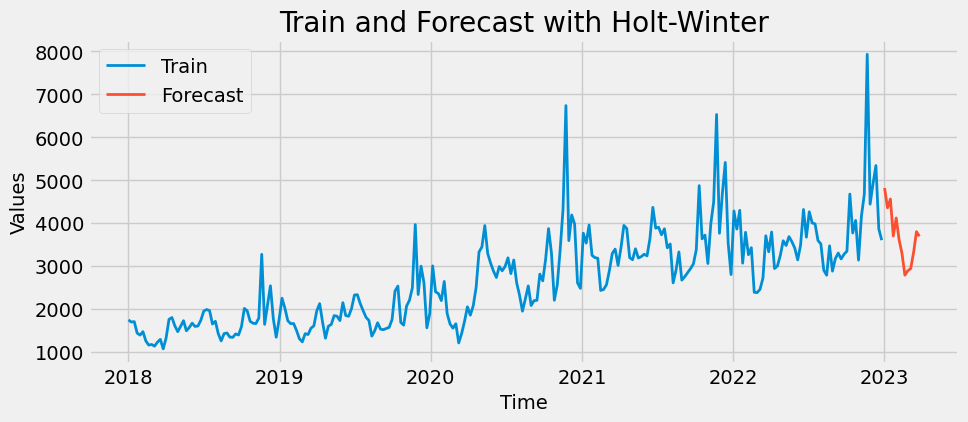

In [38]:


# plotting training and forecast
plt.figure(figsize=(10, 4))  

plt.plot(df.complaints, label='Train',linewidth=2)
plt.plot(forecast, label='Forecast',linewidth=2)


plt.legend()  
plt.title('Train and Forecast with Holt-Winter')  
plt.xlabel('Time')  
plt.ylabel('Values')  

plt.show()

# Function to plot the future 

In [40]:
def plot_future(y, forecast,title):
    
# plotting training and forecast
    plt.figure(figsize=(10, 4))  

    plt.plot(df.complaints, label='Train',linewidth=2)
    plt.plot(forecast, label='Forecast',linewidth=2)


    plt.legend()  
    plt.title(f"Train and Forecast with {title}")  
    plt.xlabel('Time')  
    plt.ylabel('Values')  

    plt.show()

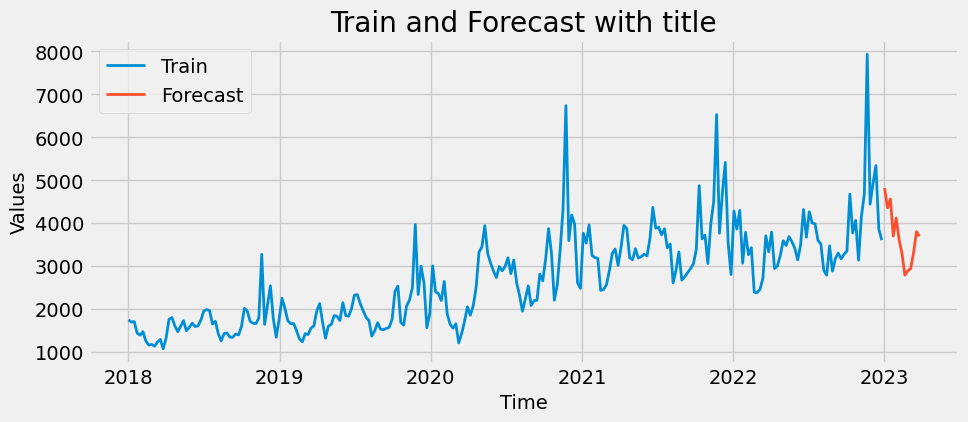

In [46]:
plot_future(df.complaints, forecast,"Holt-Winter")